In [18]:
from uninaannpy import neural_network as nn
from uninaannpy import error_functions as ef
from uninaannpy import activation_functions as af
from uninaannpy import datasets as ds
from uninaannpy import utility as ut

import numpy as np
import pandas as pd

#Lettura csv con pandas
train_data = pd.read_csv('data/mnist_train.csv')
test_data = pd.read_csv('data/mnist_test.csv')

#Ottenimento array per il training e il testing
train_array = np.array(train_data)
test_array = np.array(test_data)

#Estrapoliamo il numero di righe e di colonne di train e test
train_rows, train_cols = train_array.shape 
test_rows, test_cols = test_array.shape  

#Mescola casualmente i dati prima di suddividerli in set di sviluppo e training
np.random.shuffle(train_array)  
#Calcolo percentuale dati per il validation set
validation_percentage = 0.20
val_index = int(np.ceil(train_rows * validation_percentage))

#Distribuzione training, validation e test set
train_in, train_labels = ds.get_mnist_training(train_array, train_rows, train_cols, val_index)
validation_in, validation_labels = ds.get_mnist_validation(train_array, train_cols, val_index)
test_in, test_labels = ds.get_mnist_testing(test_array, test_cols, test_rows)

#Creazione rete neurale
#Assegnazione funzioni di attivazione per ogni strato della rete
hidden_activation_functions = [af.tanh]

#Assegnazione numero di neuroni per ogni strato
hidden_layers = [100]
#Assegnazione della funzione di attivazione e di errore per l'ultimo strato della rete
output_activation_function = af.identity
error_function = ef.cross_entropy_softmax

#Estrazione input e target
input_layer_size = train_in.shape[0]
output_layer_size = train_labels.shape[0]
net = nn.NeuralNetwork(hidden_activation_functions, output_activation_function, error_function,
                input_layer_size, hidden_layers, output_layer_size)

#Copia la rete principale in quattro per il training
std_training_net = net.duplicate_network()
plus_training_net = net.duplicate_network()
istd_training_net = net.duplicate_network()
iplus_training_net = net.duplicate_network()

std_training_net.get_net_structure()

Numero di strati nascosti: 1
Dimensione dell'input: 784
Dimensione dell'output: 10
Neuroni negli strati nascosti: 100
Funzioni di attivazione: tanh, identity
Funzione di errore: cross_entropy_softmax


In [19]:
from uninaannpy.neural_network import RPropType

# Batch training rProp standard
std_train_err, std_validation_err, std_train_accuracy, std_validation_accuracy = std_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=40, learning_rate=0.00001, rprop_type=RPropType.STANDARD)


Epoca: 0/40    rProp utilizzata: RPropType.STANDARD
    Training Accuracy: 12.58568%,
    Validation Accuracy: 12.72606%

Epoca: 1/40   rProp utilizzata: RPropType.STANDARD
    Training Accuracy: 26.51097%,
    Validation Accuracy: 26.43554%

Epoca: 2/40   rProp utilizzata: RPropType.STANDARD
    Training Accuracy: 52.99277%,
    Validation Accuracy: 53.69614%

Epoca: 3/40   rProp utilizzata: RPropType.STANDARD
    Training Accuracy: 30.12563%,
    Validation Accuracy: 29.29411%

Epoca: 4/40   rProp utilizzata: RPropType.STANDARD
    Training Accuracy: 43.02173%,
    Validation Accuracy: 42.86191%

Epoca: 5/40   rProp utilizzata: RPropType.STANDARD
    Training Accuracy: 52.66776%,
    Validation Accuracy: 53.1711%

Epoca: 6/40   rProp utilizzata: RPropType.STANDARD
    Training Accuracy: 64.47218%,
    Validation Accuracy: 63.78865%

Epoca: 7/40   rProp utilizzata: RPropType.STANDARD
    Training Accuracy: 73.95779%,
    Validation Accuracy: 74.14785%

Epoca: 8/40   rProp utilizzata:

In [20]:
from uninaannpy.neural_network import RPropType

# Batch training rProp con weight-backtracking
plus_train_err, plus_validation_err, plus_train_accuracy, plus_validation_accuracy = plus_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=40, learning_rate=0.00001, rprop_type=RPropType.RPROP_PLUS)


Epoca: 0/40    rProp utilizzata: RPropType.RPROP_PLUS
    Training Accuracy: 12.58568%,
    Validation Accuracy: 12.72606%

Epoca: 1/40   rProp utilizzata: RPropType.RPROP_PLUS
    Training Accuracy: 26.51097%,
    Validation Accuracy: 26.43554%

Epoca: 2/40   rProp utilizzata: RPropType.RPROP_PLUS
    Training Accuracy: 37.47786%,
    Validation Accuracy: 37.68647%

Epoca: 3/40   rProp utilizzata: RPropType.RPROP_PLUS
    Training Accuracy: 36.27992%,
    Validation Accuracy: 35.81132%

Epoca: 4/40   rProp utilizzata: RPropType.RPROP_PLUS
    Training Accuracy: 33.10902%,
    Validation Accuracy: 33.07776%

Epoca: 5/40   rProp utilizzata: RPropType.RPROP_PLUS
    Training Accuracy: 42.05296%,
    Validation Accuracy: 42.46187%

Epoca: 6/40   rProp utilizzata: RPropType.RPROP_PLUS
    Training Accuracy: 45.34261%,
    Validation Accuracy: 44.43704%

Epoca: 7/40   rProp utilizzata: RPropType.RPROP_PLUS
    Training Accuracy: 64.34092%,
    Validation Accuracy: 64.66372%

Epoca: 8/40   

In [21]:
from uninaannpy.neural_network import RPropType

# Batch training improved rProp con weight-backtracking
istd_train_err, istd_validation_err, istd_train_accuracy, istd_validation_accuracy = istd_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=40, learning_rate=0.00001, rprop_type=RPropType.IRPROP)


Epoca: 0/40    rProp utilizzata: RPropType.IRPROP
    Training Accuracy: 12.58568%,
    Validation Accuracy: 12.72606%

Epoca: 1/40   rProp utilizzata: RPropType.IRPROP
    Training Accuracy: 26.51097%,
    Validation Accuracy: 26.43554%

Epoca: 2/40   rProp utilizzata: RPropType.IRPROP
    Training Accuracy: 52.99277%,
    Validation Accuracy: 53.69614%

Epoca: 3/40   rProp utilizzata: RPropType.IRPROP
    Training Accuracy: 32.9736%,
    Validation Accuracy: 31.76098%

Epoca: 4/40   rProp utilizzata: RPropType.IRPROP
    Training Accuracy: 39.57582%,
    Validation Accuracy: 39.98667%

Epoca: 5/40   rProp utilizzata: RPropType.IRPROP
    Training Accuracy: 51.45732%,
    Validation Accuracy: 51.95433%

Epoca: 6/40   rProp utilizzata: RPropType.IRPROP
    Training Accuracy: 55.10948%,
    Validation Accuracy: 54.32953%

Epoca: 7/40   rProp utilizzata: RPropType.IRPROP
    Training Accuracy: 59.89916%,
    Validation Accuracy: 59.92999%

Epoca: 8/40   rProp utilizzata: RPropType.IRPRO

In [22]:
from uninaannpy.neural_network import RPropType

# Batch training improved rProp
iplus_train_err, iplus_validation_err, iplus_train_accuracy, iplus_validation_accuracy = iplus_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=40, learning_rate=0.00001, rprop_type=RPropType.IRPROP_PLUS)


Epoca: 0/40    rProp utilizzata: RPropType.IRPROP_PLUS
    Training Accuracy: 12.58568%,
    Validation Accuracy: 12.72606%

Epoca: 1/40   rProp utilizzata: RPropType.IRPROP_PLUS
    Training Accuracy: 26.51097%,
    Validation Accuracy: 26.43554%

Epoca: 2/40   rProp utilizzata: RPropType.IRPROP_PLUS
    Training Accuracy: 62.84506%,
    Validation Accuracy: 62.93024%

Epoca: 3/40   rProp utilizzata: RPropType.IRPROP_PLUS
    Training Accuracy: 35.68408%,
    Validation Accuracy: 35.5613%

Epoca: 4/40   rProp utilizzata: RPropType.IRPROP_PLUS
    Training Accuracy: 49.89896%,
    Validation Accuracy: 50.43754%

Epoca: 5/40   rProp utilizzata: RPropType.IRPROP_PLUS
    Training Accuracy: 33.30694%,
    Validation Accuracy: 32.58605%

Epoca: 6/40   rProp utilizzata: RPropType.IRPROP_PLUS
    Training Accuracy: 56.26159%,
    Validation Accuracy: 56.44637%

Epoca: 7/40   rProp utilizzata: RPropType.IRPROP_PLUS
    Training Accuracy: 58.29288%,
    Validation Accuracy: 58.21318%

Epoca: 

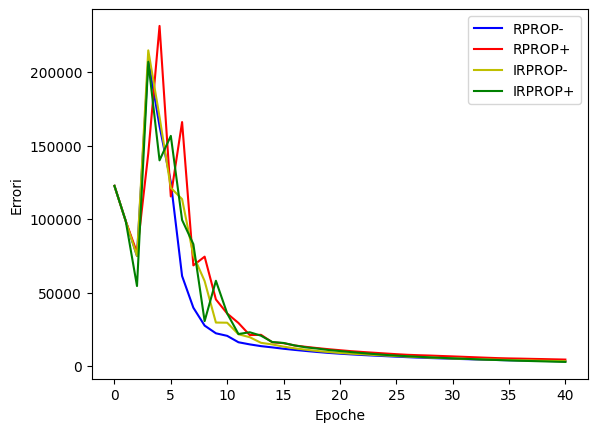

In [23]:
from matplotlib import pyplot as plt

# Stampa grafico dell'errore del training
plt.figure()
plt.plot(std_train_err, 'b', label='RPROP-')
plt.plot(plus_train_err, 'r', label='RPROP+')
plt.plot(istd_train_err, 'y', label='IRPROP-')
plt.plot(iplus_train_err, 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Errori')
plt.legend()
plt.show()

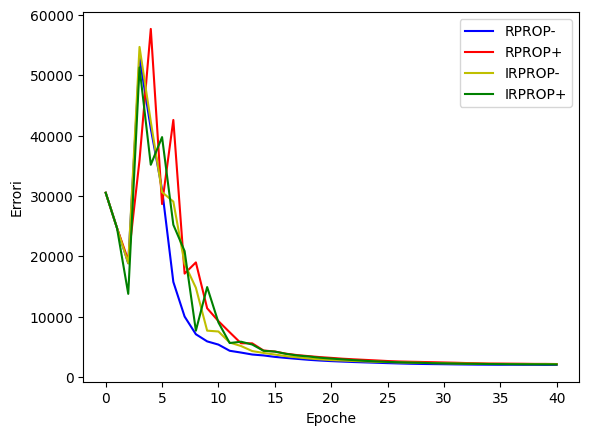

In [24]:
from matplotlib import pyplot as plt

# Stampa grafico dell'errore del validation
plt.figure()
plt.plot(std_validation_err, 'b', label='RPROP-')
plt.plot(plus_validation_err, 'r', label='RPROP+')
plt.plot(istd_validation_err, 'y', label='IRPROP-')
plt.plot(iplus_validation_err, 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Errori')
plt.legend()
plt.show()

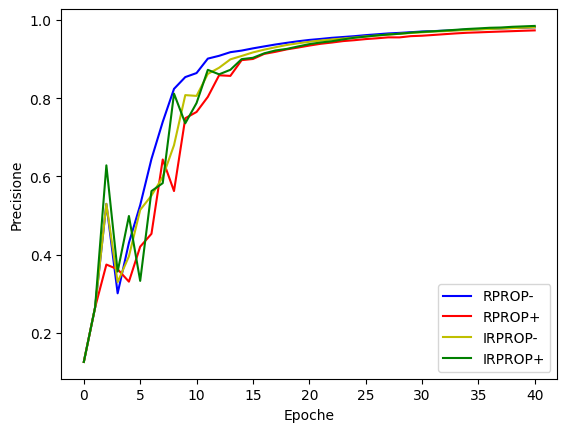

In [25]:
from matplotlib import pyplot as plt

# Stampa grafico della precisione del training
plt.figure()
plt.plot(std_train_accuracy, 'b', label='RPROP-')
plt.plot(plus_train_accuracy, 'r', label='RPROP+')
plt.plot(istd_train_accuracy, 'y', label='IRPROP-')
plt.plot(iplus_train_accuracy, 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Precisione')
plt.legend()
plt.show()

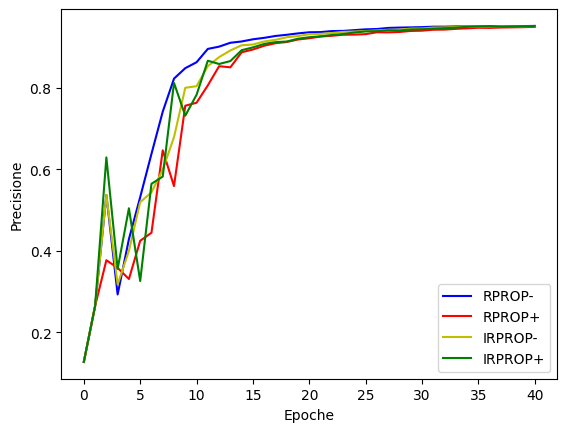

In [26]:
from matplotlib import pyplot as plt

# Stampa grafico della precisione del validation
plt.figure()
plt.plot(std_validation_accuracy, 'b', label='RPROP-')
plt.plot(plus_validation_accuracy, 'r', label='RPROP+')
plt.plot(istd_validation_accuracy, 'y', label='IRPROP-')
plt.plot(iplus_validation_accuracy, 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Precisione')
plt.legend()
plt.show()

In [27]:
#Stampa accuracy per training e test set

std_training_net.print_accuracies('Test RProp-', test_in, test_labels, train_in, train_labels)

Test RProp-
Test accuracy: 94.52229%
Train accuracy: 98.14579%


In [28]:
#Stampa accuracy per training e test set

plus_training_net.print_accuracies('Test RProp+', test_in, test_labels, train_in, train_labels)

Test RProp+
Test accuracy: 94.52229%
Train accuracy: 97.34994%


In [29]:
#Stampa accuracy per training e test set

istd_training_net.print_accuracies('Test iRProp-', test_in, test_labels, train_in, train_labels)

Test iRProp-
Test accuracy: 94.64968%
Train accuracy: 98.12704%


In [30]:
#Stampa accuracy per training e test set

iplus_training_net.print_accuracies('Test iRProp+', test_in, test_labels, train_in, train_labels)

Test iRProp+
Test accuracy: 95.92357%
Train accuracy: 98.49164%


Test rProp-
Probabilità predette dalla rete non addestrata:
Classe 0: 5.16808%
Classe 1: 7.14356%
Classe 2: 9.88068%
Classe 3: 8.83273%
Classe 4: 6.20847%
Classe 5: 9.30331%
Classe 6: 9.95506%
Classe 7: 12.18544%
Classe 8: 27.96278%
Classe 9: 3.35989%

Probabilità predette dalla rete addestrata:
Classe 0: 0.08623%
Classe 1: 0.00135%
Classe 2: 1.21374%
Classe 3: 0.00444%
Classe 4: 91.19758%
Classe 5: 0.03096%
Classe 6: 5.84982%
Classe 7: 0.04841%
Classe 8: 1.55868%
Classe 9: 0.0088%


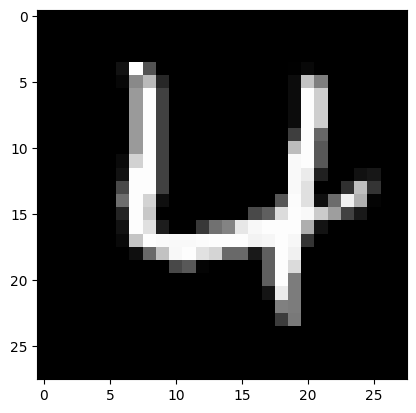

In [31]:
#Predizione rete senza addestramento e rete addestrata
image = 47993

print('Test rProp-')
ut.test_prediction(net, std_training_net, image, train_in)

Test rProp+
Probabilità predette dalla rete non addestrata:
Classe 0: 5.73709%
Classe 1: 10.34306%
Classe 2: 7.17911%
Classe 3: 19.33272%
Classe 4: 17.21841%
Classe 5: 12.38962%
Classe 6: 4.90118%
Classe 7: 12.3188%
Classe 8: 5.61562%
Classe 9: 4.96439%

Probabilità predette dalla rete addestrata:
Classe 0: 71.1673%
Classe 1: 0.18423%
Classe 2: 0.3617%
Classe 3: 2.0421%
Classe 4: 0.07699%
Classe 5: 3.10772%
Classe 6: 13.86416%
Classe 7: 0.00208%
Classe 8: 8.52529%
Classe 9: 0.66845%


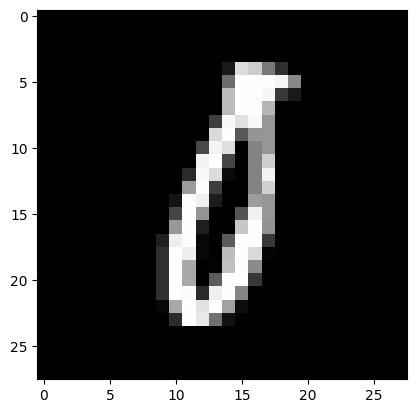

In [32]:
#Predizione rete senza addestramento e rete addestrata
image = 47993

print('Test rProp+')
ut.test_prediction(net, plus_training_net, image, train_in)

Test irProp-
Probabilità predette dalla rete non addestrata:
Classe 0: 5.73709%
Classe 1: 10.34306%
Classe 2: 7.17911%
Classe 3: 19.33272%
Classe 4: 17.21841%
Classe 5: 12.38962%
Classe 6: 4.90118%
Classe 7: 12.3188%
Classe 8: 5.61562%
Classe 9: 4.96439%

Probabilità predette dalla rete addestrata:
Classe 0: 22.08793%
Classe 1: 0.01847%
Classe 2: 3.13685%
Classe 3: 1.68995%
Classe 4: 0.02844%
Classe 5: 5.24526%
Classe 6: 23.95644%
Classe 7: 0.00073%
Classe 8: 42.08861%
Classe 9: 1.74732%


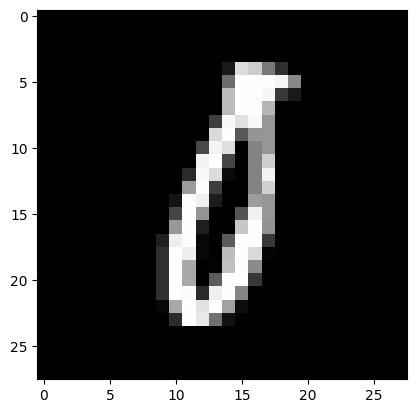

In [33]:
#Predizione rete senza addestramento e rete addestrata
image = 47993

print('Test irProp-')
ut.test_prediction(net, istd_training_net, image, train_in)

Test irProp+
Probabilità predette dalla rete non addestrata:
Classe 0: 5.73709%
Classe 1: 10.34306%
Classe 2: 7.17911%
Classe 3: 19.33272%
Classe 4: 17.21841%
Classe 5: 12.38962%
Classe 6: 4.90118%
Classe 7: 12.3188%
Classe 8: 5.61562%
Classe 9: 4.96439%

Probabilità predette dalla rete addestrata:
Classe 0: 61.06755%
Classe 1: 2.11745%
Classe 2: 0.21746%
Classe 3: 4.22718%
Classe 4: 0.02045%
Classe 5: 2.31924%
Classe 6: 27.32038%
Classe 7: 0.00043%
Classe 8: 2.27202%
Classe 9: 0.43784%


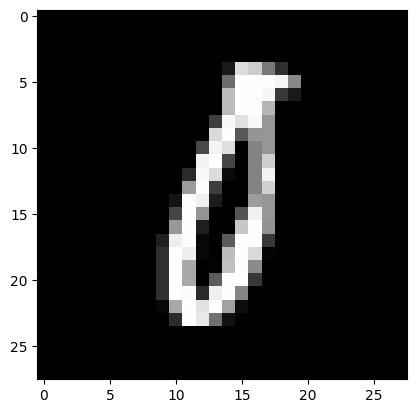

In [34]:
#Predizione rete senza addestramento e rete addestrata
image = 47993

print('Test irProp+')
ut.test_prediction(net, iplus_training_net, image, train_in)